In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_squared_error,  mean_absolute_error
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking learning_raterun or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/sample.csv.csv
/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/train.csv
/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/test.csv


In [2]:
# '''Create path variables for train and test data file locations'''

train_path = "/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/train.csv"
test_path = "/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/test.csv"

In [3]:
# Initialize empty lists to capture model,score for each estimator and plot their comparsion insights

train = []
val = []

In [4]:
# '''Define a function to read train and test data files into pandas DataFrame'''

def fetch_dataset(path):
    '''returns a DataFrame with rows from the file'''
    df = pd.read_csv(path)
    return df

In [5]:
# '''Load Train & Test datasets into pandas DataFrames'''

data = fetch_dataset(train_path)
test = fetch_dataset(test_path)

In [6]:
# Print top 10 rows to visualize the dataset
data.head(10)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,extra,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,1,2023-06-28 17:20:21,2023-06-28 16:34:45,1.0,2.14,1.0,N,120,9,Credit Card,2.5,7.165589,0.0,1.0,20.64,2.5,0.0
1,0,2023-06-29 23:05:01,2023-06-29 22:01:35,1.0,2.70,1.0,N,15,215,Credit Card,3.5,6.067401,0.0,1.0,25.55,2.5,0.0
2,1,2023-06-30 10:19:31,2023-06-30 11:13:10,1.0,1.15,1.0,N,167,223,Credit Card,0.0,4.111547,0.0,1.0,17.64,2.5,0.0
3,0,2023-06-29 13:23:09,2023-06-29 14:20:01,1.0,0.40,1.0,N,128,239,Credit Card,2.5,6.411079,0.0,1.0,12.80,2.5,0.0
4,1,2023-06-29 22:03:32,2023-06-29 22:22:22,3.0,1.10,1.0,N,203,52,Credit Card,1.0,4.769377,0.0,1.0,18.00,2.5,0.0
5,0,2023-06-29 16:31:14,2023-06-29 16:29:06,1.0,0.00,99.0,N,225,256,Credit Card,0.0,1.507831,0.0,1.0,44.70,0.0,0.0
6,1,2023-06-30 12:54:57,2023-06-30 11:52:20,1.0,1.33,1.0,N,214,240,Cash,0.0,0.094334,0.0,1.0,18.20,2.5,0.0
7,1,2023-06-30 17:16:44,2023-06-30 17:40:34,1.0,0.45,1.0,N,176,227,Cash,2.5,0.727105,0.0,1.0,13.70,2.5,0.0
8,0,2023-06-30 21:52:44,2023-06-30 21:54:13,3.0,3.80,1.0,N,196,139,Credit Card,3.5,6.590745,0.0,1.0,35.60,2.5,0.0
9,1,2023-06-29 11:12:12,2023-06-29 09:39:24,1.0,2.50,1.0,N,138,196,Credit Card,0.0,6.091603,0.0,1.0,23.10,2.5,0.0


# **Exploratory Data Analysis (EDA)**
Perform following steps for data analysis
1. Total number of features and data samples in the train dataset
2. Identify number of Numeric and Categorical features
3. Correlation between numeric features and plot data distribution for each feature
4. Features with missing values

In [7]:
# Total number of Features and Data Samples in the Train & Test dataset

print("Training dataset has {} samples and {} features\n" .format(data.shape[0], data.shape[1]))
print("Test dataset has {} samples and {} features\n" .format(test.shape[0], test.shape[1]))

# Separate our Numeric and Categorical Features
print("Following features in the dataset are Numeric:\n {}\n".format(data.select_dtypes(include=['number']).columns))
print("Following features in the dataset are Categorical:\n {}\n".format(data.select_dtypes(include=['object']).columns))

#Identify all the Features with missing values
# print(data.isna().sum() != 0)
print("Following features in the dataset have missing values {}\n".format(data.columns[data.isnull().any()]))

Training dataset has 175000 samples and 17 features

Test dataset has 50000 samples and 16 features

Following features in the dataset are Numeric:
 Index(['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID',
       'PULocationID', 'DOLocationID', 'extra', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount', 'congestion_surcharge',
       'Airport_fee'],
      dtype='object')

Following features in the dataset are Categorical:
 Index(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'store_and_fwd_flag',
       'payment_type'],
      dtype='object')

Following features in the dataset have missing values Index(['passenger_count', 'RatecodeID', 'store_and_fwd_flag',
       'congestion_surcharge', 'Airport_fee'],
      dtype='object')



In [8]:
# Descriptive statistics for continuous attributes

print(data[['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID',
       'PULocationID', 'DOLocationID', 'extra', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount', 'congestion_surcharge',
       'Airport_fee']].describe())

            VendorID  passenger_count  trip_distance     RatecodeID  \
count  175000.000000    168923.000000  175000.000000  168923.000000   
mean        0.728377         1.357678       5.145930       1.518307   
std         0.445606         0.891283     394.971052       6.514678   
min         0.000000         0.000000       0.000000       1.000000   
25%         0.000000         1.000000       1.080000       1.000000   
50%         1.000000         1.000000       1.840000       1.000000   
75%         1.000000         1.000000       3.610000       1.000000   
max         2.000000         9.000000  135182.060000      99.000000   

        PULocationID   DOLocationID          extra     tip_amount  \
count  175000.000000  175000.000000  175000.000000  175000.000000   
mean      132.710349     132.701429       1.932143       6.127497   
std        76.148799      76.192493       1.948497       4.610834   
min         1.000000       1.000000      -7.500000       0.000079   
25%        67.0

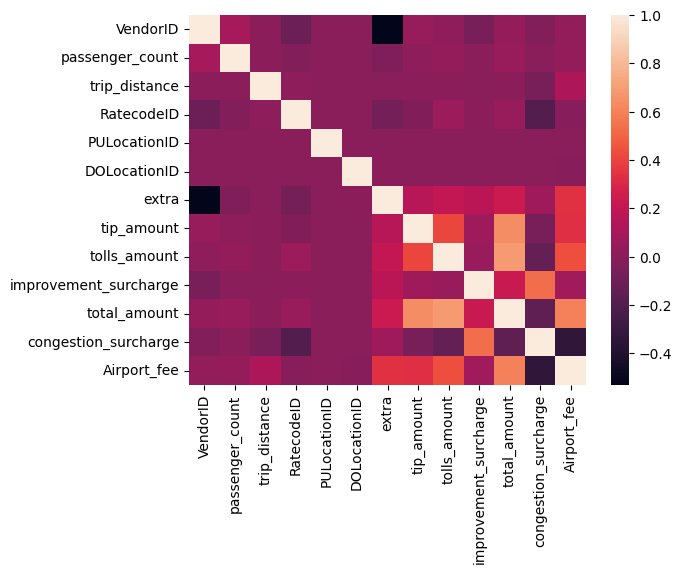

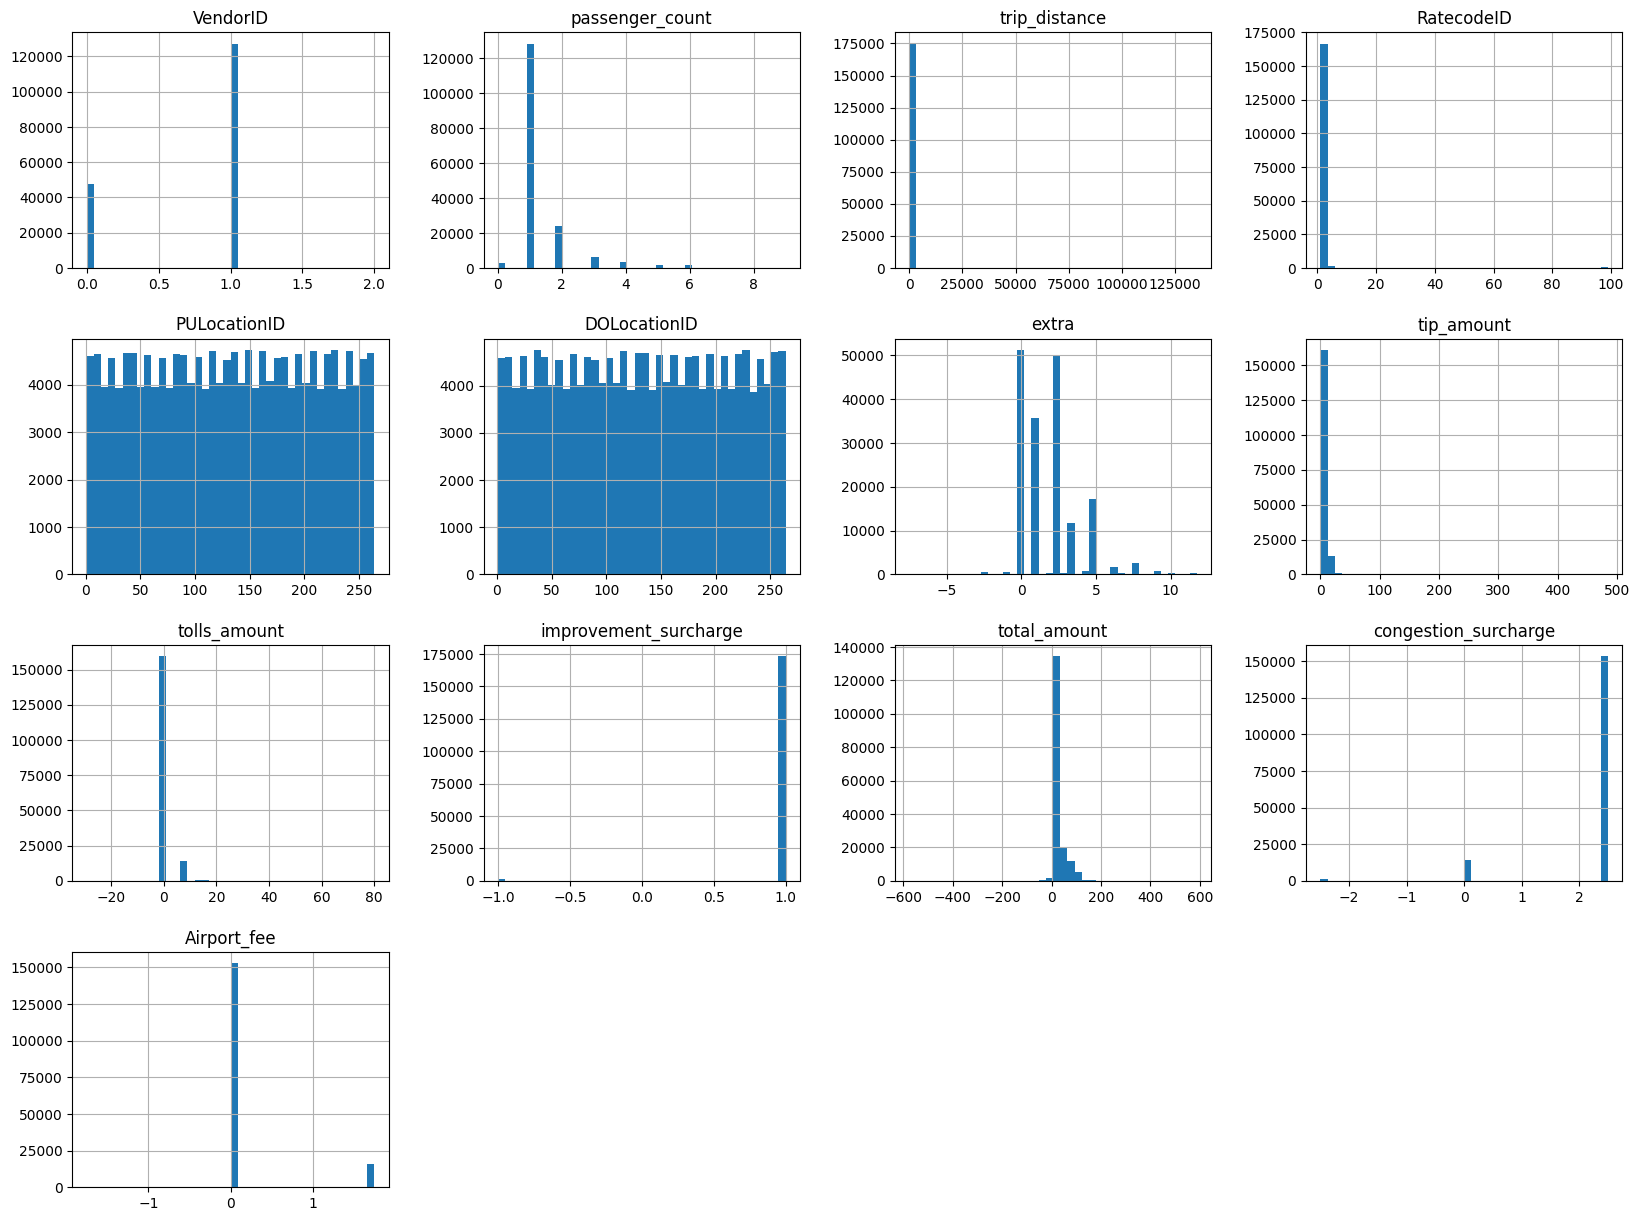

In [9]:
# Identify Correlation between numeric features and plot data distribution for each feature

sns.heatmap(data.corr(numeric_only=True))
data.hist(bins=40, figsize=(20,15)) 
plt.show()

# **FEATURE ENGINEERING**

In [10]:
# '''Define a function to cleanse and prepare traind/test dataset for preprocessing and eventual model training'''

def cleanse(df):
    
#     ''' As part of below steps, translate pickup and dropoff to datetime datatype. Subsequently, perform
#      feature engineering and generate 3 new features: trip duration, trip day and trip hour'''
    
    df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
    df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
    df['tpep_duration'] = np.abs((df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime'])/np.timedelta64(1,'m'))
    df['tpep_day_of_week'] = df['tpep_pickup_datetime'].dt.dayofweek
    df['tpep_hour'] = np.where((df['tpep_pickup_datetime'].dt.hour < df['tpep_dropoff_datetime'].dt.hour), 
                               df['tpep_pickup_datetime'].dt.hour,df['tpep_dropoff_datetime'].dt.hour)
    
#     ''' convert -ve $ amounts using numpy absolute method to ensure consistent model learning'''
    
    df.extra = np.abs(df.extra)
    df.tolls_amount = np.abs(df.tolls_amount)
    df.improvement_surcharge = np.abs(df.improvement_surcharge)
    df.congestion_surcharge = np.abs(df.congestion_surcharge)
    df.Airport_fee = np.abs(df.Airport_fee)

#     '''feature engineering to supress impact of outliers in payment_type, VendorID, and passenger_count features'''
    
    df.loc[df.payment_type == 'Wallet', 'payment_type'] = 'unknown'
    df.loc[df.VendorID == 2, 'VendorID'] = 0
    df.loc[(df.passenger_count == 0) | (df.passenger_count > 6), 'passenger_count'] = 1
    df.loc[df.passenger_count.isnull(), 'passenger_count'] = 1
#     df.loc[(df.trip_distance > 200),'trip_distance'] = np.mean(df.loc[(df.trip_distance <= 200)].trip_distance)

        
#     '''drop features with least importance. Note that these features have been identified based on correlation and feature improtance
#     from regression techniques'''
    
    df = df.drop([ 'tpep_pickup_datetime','tpep_dropoff_datetime',
                  'PULocationID', 'DOLocationID',
                  'store_and_fwd_flag'], axis=1)
    
    return df
    

# Dataset Cleaning, Feature/Label Matrix Creation, Test-Train Split & Pipeline Preprocessing

In [11]:
# Clean the train dataset using defined cleanse function, and separate train (X) & label (y) from the dataframe

data = cleanse(data)
# data = data.loc[(data.trip_distance <= 200)].reset_index(drop=True)
data.total_amount = np.abs(data.total_amount)
X, y = data.drop(['total_amount'], axis=1), data.total_amount

In [12]:
# Split dataset into train & test datasets with test size of 0.20 % and publish their shapes

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

print("Shape of Train dataset {}".format(X_train.shape), "Shape of Validation dataset {}".format(X_val.shape),
     "Shape of Train Label dataset {}".format(y_train.shape), "Shape of Validation Label dataset {}".format(y_val.shape), 
      sep = '\n')

Shape of Train dataset (140000, 14)
Shape of Validation dataset (35000, 14)
Shape of Train Label dataset (140000,)
Shape of Validation Label dataset (35000,)


In [13]:
# Define separate pipelines for preprocesing Categorical & Numeric Variables.

# Categorical Pipeline uses Column Transformer (to collect all Categorical Features)
# SimpleImputer (to impute missing values using 'most_frequent' strategy)
# OneHotEncoder (to encode Categorical Features)
# Subsequently, use Feature Union to combine and create final training dataset

cat_pipeline = Pipeline([
    ('selector',ColumnTransformer([("passthrough", 'passthrough', ['VendorID', 'payment_type','RatecodeID',])])),
    ("impute", SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore')),
])

# Numeric Pipeline uses Column Transformer (to collect all Numeric Features)
# SimpleImputer (to impute missing values using 'mean' strategy) 
# StandardScaler (to scale Numeric Features)


num_pipeline = Pipeline([
    ('selector',ColumnTransformer([('numeric','passthrough',[ 'passenger_count','trip_distance','extra', 'tip_amount', 'tolls_amount',
    'improvement_surcharge','congestion_surcharge','Airport_fee','tpep_duration','tpep_hour','tpep_day_of_week'])])),
    ('imputer', SimpleImputer(strategy='mean')),
    ('std_scaler', StandardScaler()),
])

# Feature Union to combine and create final transformed dataset

full_pipeline = FeatureUnion(transformer_list=[("num_pipeline", num_pipeline),("cat_pipeline", cat_pipeline)])

In [14]:
# Apply preprocessing to both Train & Validation datasets, and publish names of final set of features

X_train_tr = full_pipeline.fit_transform(X_train)
X_val_tr = full_pipeline.transform(X_val)
full_pipeline.get_feature_names_out()

array(['num_pipeline__numeric__passenger_count',
       'num_pipeline__numeric__trip_distance',
       'num_pipeline__numeric__extra',
       'num_pipeline__numeric__tip_amount',
       'num_pipeline__numeric__tolls_amount',
       'num_pipeline__numeric__improvement_surcharge',
       'num_pipeline__numeric__congestion_surcharge',
       'num_pipeline__numeric__Airport_fee',
       'num_pipeline__numeric__tpep_duration',
       'num_pipeline__numeric__tpep_hour',
       'num_pipeline__numeric__tpep_day_of_week',
       'cat_pipeline__passthrough__VendorID_0',
       'cat_pipeline__passthrough__VendorID_1',
       'cat_pipeline__passthrough__payment_type_Cash',
       'cat_pipeline__passthrough__payment_type_Credit Card',
       'cat_pipeline__passthrough__payment_type_UPI',
       'cat_pipeline__passthrough__payment_type_unknown',
       'cat_pipeline__passthrough__RatecodeID_1.0',
       'cat_pipeline__passthrough__RatecodeID_2.0',
       'cat_pipeline__passthrough__RatecodeID_3.0',


In [15]:
# publish the shapes of Transformed Train & Validation datasets

print("Shape of transformed Train dataset {}".format(X_train_tr.shape), 
      "Shape of transformed Validation dataset {}".format(X_val_tr.shape), 
      sep = '\n')

Shape of transformed Train dataset (140000, 23)
Shape of transformed Validation dataset (35000, 23)


# LINEAR REGRESSION

In [16]:
# Instantiate and fit LinearRegression using transformed Train dataset

lr = LinearRegression(fit_intercept=True)

lr.fit(X_train_tr, y_train)

#  Compute RMSE & Score (Training & Validation) scores for the LinearRegression object

train.append(('lr', lr.score(X_train_tr, y_train)))
val.append(('lr', lr.score(X_val_tr, y_val)))

print("Training Scores:",lr.score(X_train_tr, y_train))
print("Validation Score:",lr.score(X_val_tr, y_val))
print("RMSE Training:",np.sqrt(mean_squared_error(y_train, lr.predict(X_train_tr))))
print("RMSE Validation:",np.sqrt(mean_squared_error(y_val, lr.predict(X_val_tr))))

Training Scores: 0.7708910880080713
Validation Score: 0.7710186477560617
RMSE Training: 11.845829390153758
RMSE Validation: 11.888590375359021


In [17]:
# Perform 10 Fold Cross Validation with neg_mean_squared_error as scoring mechanism

cv_lr = cross_validate(lr, X_train_tr, y_train, scoring="neg_mean_squared_error", cv=10, 
                       return_train_score=True, return_estimator=True)

cv_lr_rmse = np.sqrt(-cv_lr['train_score'])

#Print RMSE for each fold, along wit Mean RMSE & Standard Deviation

for i in range(len(cv_lr_rmse)):
    print(f"RMSE for {i}th fold: {cv_lr_rmse[i]}")
    
print("Mean RMSE across all folds:", cv_lr_rmse.mean())

print("Standard deviation:", cv_lr_rmse.std())

RMSE for 0th fold: 11.827201401059797
RMSE for 1th fold: 11.841478858573868
RMSE for 2th fold: 11.884797574941356
RMSE for 3th fold: 11.803267240528415
RMSE for 4th fold: 11.960453593549873
RMSE for 5th fold: 11.885028706977524
RMSE for 6th fold: 11.96544947252585
RMSE for 7th fold: 11.776913374180664
RMSE for 8th fold: 11.73182193884548
RMSE for 9th fold: 11.762303267459757
Mean RMSE across all folds: 11.84387154286426
Standard deviation: 0.07574010917806315


In [18]:
# Publish coefficients of Linear Regression estimators for best estimator from Cross Validation & regular Linear Regression estimators

lr.coef_, cv_lr['estimator'][8].coef_

(array([ 1.91470251e-01,  3.41431153e-02,  1.78367257e+00,  8.76518863e+00,
         7.73574539e+00, -1.58278250e-01, -1.59066293e+00,  4.41188887e+00,
         8.03966764e-01, -1.86726433e-01, -1.17407736e-01, -1.45158792e+00,
         1.45158792e+00,  1.58917346e+00, -1.86193268e+00, -3.63044356e+00,
         3.90320278e+00, -2.89507201e+01, -3.21405830e+00, -8.11413836e+00,
         3.87839746e+01,  1.74793419e+01, -1.59843997e+01]),
 array([ 1.84047827e-01,  2.88123974e-02,  1.81033020e+00,  8.73878356e+00,
         7.59834327e+00, -1.10998838e-01, -1.53090173e+00,  4.45246492e+00,
         7.79615481e-01, -1.80959482e-01, -1.05930114e-01, -1.46811233e+00,
         1.46811233e+00,  1.52461658e+00, -1.89678491e+00, -3.52591975e+00,
         3.89808808e+00, -2.93899978e+01, -3.34806678e+00, -7.48161863e+00,
         4.13182570e+01,  1.51434220e+01, -1.62419958e+01]))

# LIGHT GBM REGRESSOR WITH GRID SEARCH CROSS VALIDATION FOR HYPER PARAMATER TUNING

In [19]:
# # Initiate the instance of default instance Light GBM Regressor

# lgbmr = LGBMRegressor(random_state = 42)

# # Define the Param Dictonary for various combinations for which Hyperparameter tunning is needed

# param_range = {
#         'num_leaves': [50, 100, 150],
#         'min_child_samples': [30, 50, 100],
#         'Subsample': [0.7, 0.8, 0.9], 
#         'colsample_bytree': [0.7, 0.8, 0.9], 
#         'reg_alpha': [0, 1],
#         'reg_lambda': [0, 1]
#     }


# # Run GridSeachCV with 5-fold Cross Validation to identify the Best parameters

# lgbmr_gsv = GridSearchCV(
#     estimator=lgbmr,
#     param_grid=param_range,
#     scoring = 'neg_root_mean_squared_error',
#     n_jobs = -1,
#     cv = 5,
#     verbose=True
# )

# # Fit transformer to identify the best estimator and respective params for LGBMRegressor

# lgbmr_gsv.fit(X_train_tr, y_train)

# lgbmr_gsv.best_estimator_.get_params()

In [20]:
# Initiate instance of Light GBM Regressor with Best Parameters from Hyper Tuning

lgbmr = LGBMRegressor(subsample=0.7, colsample_bytree=0.8, min_child_samples=50, num_leaves=150, reg_lambda=0, reg_alpha=1, random_state = 42) 
#reg_lambda alias L2 and reg_alpha alias L1

#  Fit the Estimator & compute RMSE & Score (Training & Validation) scores

lgbmr.fit(X_train_tr, y_train)

train.append(('lgbmr', lgbmr.score(X_train_tr, y_train)))
val.append(('lgbmr', lgbmr.score(X_val_tr, y_val)))

print("Training Scores:",lgbmr.score(X_train_tr, y_train))
print("Validation Score:",lgbmr.score(X_val_tr, y_val))
print("RMSE Training:",np.sqrt(mean_squared_error(y_train, lgbmr.predict(X_train_tr))))
print("RMSE Validation:",np.sqrt(mean_squared_error(y_val, lgbmr.predict(X_val_tr))))

Training Scores: 0.9547687724022039
Validation Score: 0.9423749387821855
RMSE Training: 5.263367195909743
RMSE Validation: 5.963977626876335


# MULTILAYER PERCEPTRON REGRESSOR WITH GRID SEARCH CROSS VALIDATION FOR HYPER PARAMATER TUNING

In [21]:
# # Initiate the instance of default instance Light GBM Regressor

# mlpr = MLPRegressor(random_state = 42)

# # Define the Param Dictonary for various combinations for which Hyperparameter tunning is needed

# param_grid = {'hidden_layer_sizes': [(50,50),(100,50), (50,50,50)],
#               'alpha': [0.0001, 0.0002],
#               'learning_rate': ['constant','adaptive'],
#              }

# # Run GridSeachCV with 3-fold Cross Validation to identify the Best parameters for MLP Regressor

# mlpr_gsv = GridSearchCV(
#     mlpr,
#     param_grid,
#     cv=3, 
#     scoring='neg_mean_squared_error', 
#     verbose=0, n_jobs=-1)

# # Fit transformer to identify the best estimator for MLPRegressor

# mlpr_gsv.fit(X_train_tr, y_train)

# mlpr_gsv.best_estimator_.get_params()

In [22]:
# Initiate instance of MLP Regressor with Best Parameters from Hyper Tuning

mlpr = MLPRegressor(hidden_layer_sizes = (100,50), max_iter = 300, 
                       random_state = 42, n_iter_no_change = 50, early_stopping = True)

#  Fit the Estimator & compute RMSE & Score (Training & Validation) scores

mlpr.fit(X_train_tr, y_train)

train.append(('mlpr', mlpr.score(X_train_tr, y_train)))
val.append(('mlpr', mlpr.score(X_val_tr, y_val)))

print("Training Scores:",mlpr.score(X_train_tr, y_train))
print("Validation Score:",mlpr.score(X_val_tr, y_val))
print("RMSE Training:",np.sqrt(mean_squared_error(y_train, mlpr.predict(X_train_tr))))
print("RMSE Validation:",np.sqrt(mean_squared_error(y_val, mlpr.predict(X_val_tr))))
print("Number of iteration taken for Convergence:",mlpr.n_iter_)

Training Scores: 0.9589741589462334
Validation Score: 0.9587616988398084
RMSE Training: 5.012717483718434
RMSE Validation: 5.045226737761409
Number of iteration taken for Convergence: 208


# XGBOOST REGRESSOR WITH GRID SEARCH CROSS VALIDATION FOR HYPER PARAMATER TUNING

In [23]:
# # Initiate the instance of default instance XGBOOST Regressor

# xgbr =  XGBRegressor(objective ='reg:squarederror', random_state = 42)

# # Define the Param Dictonary for various combinations for which Hyperparameter tunning is needed

# parameters = {
#     'learning_rate': [0.1, 0.3],
#     'max_depth': [5, 6, 7],
#     'n_estimators': [100, 150],
#     'subsample': [0.8, 0.9],
#     'colsample_bytree':[0.8, 0.9],
#    'gamma':[i/10.0 for i in range(0,3)]
# }

# # Run GridSeachCV with 5-fold Cross Validation to identify the Best parameters for XGBOOST Regressor

# xgbr_gsv = GridSearchCV(
#     estimator=xgbr,
#     param_grid=parameters,
#     scoring = 'neg_root_mean_squared_error',
#     n_jobs = -1,
#     cv = 5,
#     verbose=True
# )

# # Fit transformer to identify the best estimator for XGBRegressor

# xgbr_gsv.fit(X_train_tr, y_train)

# xgbr_gsv.best_estimator_.get_params()

In [24]:
# Initiate instance of XGBOOST Regressor with Best Parameters from Hyper Tuning

xgbr = XGBRegressor(objective ='reg:squarederror',random_state = 42)

#  Fit the Estimator & compute RMSE & Score (Training & Validation) scores

xgbr.fit(X_train_tr, y_train)

train.append(('xgbr', xgbr.score(X_train_tr, y_train)))
val.append(('xgbr', xgbr.score(X_val_tr, y_val)))

print("Training Scores:",xgbr.score(X_train_tr, y_train))
print("Validation Score:",xgbr.score(X_val_tr, y_val))
print("RMSE Training:",np.sqrt(mean_squared_error(y_train, xgbr.predict(X_train_tr))))
print("RMSE Validation:",np.sqrt(mean_squared_error(y_val, xgbr.predict(X_val_tr))))

Training Scores: 0.9785881604712608
Validation Score: 0.9634035679477893
RMSE Training: 3.621358095930619
RMSE Validation: 4.752801525712096


In [25]:
# Identify feature importance based on XGBRegressor Estimator fit
xgbr.feature_importances_

array([0.00735128, 0.42676085, 0.00760914, 0.02820152, 0.0290157 ,
       0.00388556, 0.01036439, 0.00428865, 0.00526145, 0.00717521,
       0.00480789, 0.01155799, 0.        , 0.01001997, 0.01198978,
       0.01944923, 0.00522559, 0.27085122, 0.02871205, 0.01676419,
       0.04219154, 0.00842336, 0.04009345], dtype=float32)

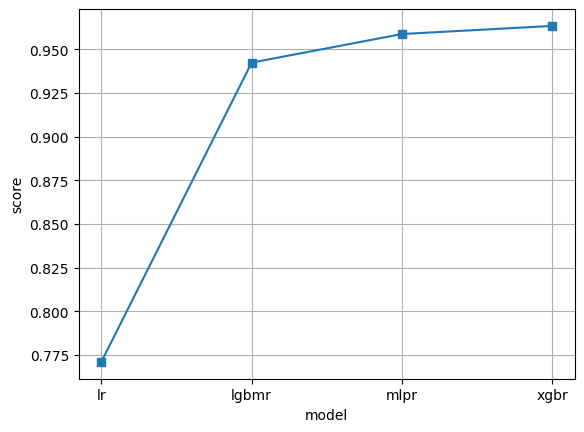

In [26]:
# Compare and plot validation scores of Linear Regression, LGBMRegressor, MLPRegressor & XGBOOST

tmodel, tscore = zip(*train)
vmodel, vscore = zip(*val)
plt.xlabel("model")
plt.ylabel("score")
plt.plot(vmodel, vscore,'-s')
plt.grid(True)
plt.show()

In [27]:
# Create copy of test data to be used for inversing total_amount to -ve
ot = test.copy(deep=True)

# Clean the Test dataset using defined cleanse function
test = cleanse(test)

# Apply preprocessing to test dataset
x_test = full_pipeline.transform(test)

# Make prediction using Estimator with best validation score
y_test_pred= mlpr.predict(x_test)


# Create result dataframe with 'total_amount' from the predictions
result = pd.DataFrame({'total_amount': y_test_pred})

# Convert 'total_amount' to -ve if any of the columns in copied dataframe (extra, tolls_amount,improvement_surcharge, 
# congestion_surcharge, Airport_fee) is negative

result['total_amount'] = np.where((ot.extra < 0) | (ot.tolls_amount < 0) | (ot.improvement_surcharge < 0) 
                                  | (ot.congestion_surcharge < 0)  | (ot.Airport_fee < 0), -1 * result['total_amount'], result['total_amount'])

# Reset the index to start from 1 and create submission.csv 
result = result.reset_index()
result = result.rename(columns={"index":"ID"})
result['ID'] = result.index + 1

result.to_csv('/kaggle/working/submission.csv', index=False)